<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/TP_ADVERSAIRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#deep learning sous attaque adversaire

L'objet de ce TP est de démontrer
- la faciliter de produire des attaques adversaires "white box" sur des réseaux naifs quelles soient invisibles ou par patch
- mais que cela est beaucoup plus dur sur un réseau robustifier (cas invisible)
- ou encore qu'il est beaucoup plus difficile de produire des attaques "transferable"

## generalité

Commençons par télécharger 10 images d'imagenet.

In [1]:
!rm -f *
!wget https://httpmail.onera.fr/21/500df56b6a7a034ecc2f3e0345f1ce9cYqsE3G/data.zip
!unzip data.zip
!ls

rm: cannot remove 'sample_data': Is a directory
--2024-09-25 07:00:55--  https://httpmail.onera.fr/21/500df56b6a7a034ecc2f3e0345f1ce9cYqsE3G/data.zip
Resolving httpmail.onera.fr (httpmail.onera.fr)... 144.204.16.9
Connecting to httpmail.onera.fr (httpmail.onera.fr)|144.204.16.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 723589 (707K) [application/force-download]
Saving to: ‘data.zip’

data.zip            100%[===================>] 706.63K   842KB/s    in 0.8s    

2024-09-25 07:00:57 (842 KB/s) - ‘data.zip’ saved [723589/723589]

Archive:  data.zip
 extracting: 0.png                   
  inflating: 1.png                   
 extracting: 2.png                   
 extracting: 3.png                   
  inflating: 4.png                   
 extracting: 5.png                   
 extracting: 6.png                   
 extracting: 7.png                   
 extracting: 8.png                   
 extracting: 9.png                   
0.png  1.png  2.png  3.png  4.png 

Affichons les : les 5 premières sont des "avions" et les 5 suivantes des "requins"

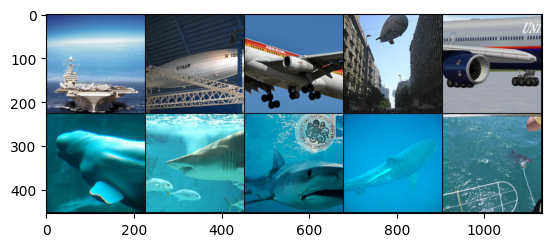

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt

x = [torchvision.io.read_image(str(i)+".png") for i in range(10)]
x = torch.stack(x,dim=0).float()/255

visu = torchvision.utils.make_grid(x, nrow=5)
plt.imshow(visu.permute(1, 2, 0).numpy())
plt.show()

In [3]:
SHARK, PLANE = [2, 3, 4], [403, 404, 405]
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
resnet = torchvision.models.resnet101(
    weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1
).eval()

with torch.no_grad():
    z = resnet(normalize(x))
    _,z = z.max(1)
    print(z)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:06<00:00, 26.7MB/s]


tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2])


On voit que le réseau classe correctement ces images.

## Attaque

On va maintenant rajouter à ces images un petit bruit "invisible" pour l'oeil mais perturbant pour le réseau.

In [6]:
y = torch.Tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2]).long()

cefunction = torch.nn.CrossEntropyLoss()
attaque = torch.zeros(x.shape)

for j in range(y.shape[0]):
    print(j)
    optimizer = torch.optim.SGD([attaque],lr=0.005)
    xtmp = x[j].view(1,3,224,224)
    ytmp = (y[j]*torch.ones(1)).long()
    atmp = torch.nn.Parameter(torch.zeros(1,3,224,224, requires_grad=True))
    for i in range(10):
      z = resnet(normalize(xtmp+atmp))
      ce = cefunction(z,ytmp)
      if i%5==4:
          print(i,float(ce))
      ce = -ce # on veut MAXIMISER la cross entropy puisqu'on attaque
      optimizer.zero_grad()
      ce.backward()
      atmp.grad = atmp.grad.sign()
      optimizer.step()
      with torch.no_grad():
          # l'attaque doit être invisible
          atmp = torch.clamp(atmp, -10./255,+10./255)

          # attaque+x doit être entre 0 et 1
          lowbound = -xtmp
          uppbound = 1-xtmp
          atmp = lowbound*(atmp<lowbound).float() + uppbound*(atmp>uppbound).float() + atmp *(atmp>=lowbound).float()*(atmp<=uppbound).float()

          attaque[j]=atmp.clone()

      atmp = torch.nn.Parameter(atmp.clone())
      optimizer = torch.optim.SGD([atmp],lr=0.005)


with torch.no_grad():
    z = resnet(normalize(x+attaque))
    _,z = z.max(1)
    print(z)

0
4 16.748836517333984
9 50.191017150878906
1
4 16.959592819213867
9 34.53539276123047
2
4 13.976665496826172
9 41.1468620300293
3
4 20.09012222290039
9 45.14055633544922
4
4 10.365514755249023
9 48.804500579833984
5
4 16.43503189086914
9 27.3001708984375
6
4 29.19751739501953
9 53.561058044433594
7
4 11.841076850891113
9 23.443517684936523
8
4 10.139976501464844
9 48.47247314453125
9
4 9.533774375915527
9 23.18205451965332
tensor([562, 517, 657, 682, 709, 149, 296,   2, 845,   4])


Les images "x+attaque" sont désormais mal classées !
Pourtant, l'attaque ne se voit pas :

tensor([562, 517, 657, 682, 709, 149, 296,   2, 845,   4])


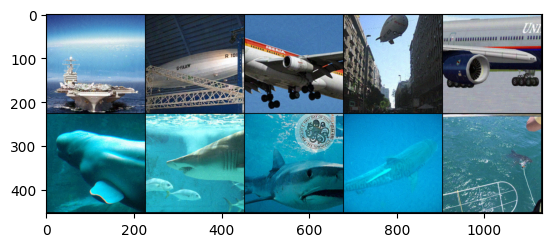

In [7]:
with torch.no_grad():
    z = resnet(normalize(x+attaque))
    _,z = z.max(1)
    print(z)

visu = torchvision.utils.make_grid(x+attaque, nrow=5)
plt.imshow(visu.permute(1, 2, 0).numpy())
plt.show()